In [1]:
# install packages if imports dont work

import numpy as np
import pandas as pd
import seaborn as sns
import os
from numpy.polynomial import polynomial as P # for continuous dependent variable
from matplotlib import pyplot as plt

In [2]:
# Setting working directory

print(f'Before={os.getcwd()}') # Set wd to \sciebo\GuiltAndResponsibility
#os.chdir('C:\\Users\\1412r\\sciebo\\GuiltAndResponsibility')
#print(f'After={os.getcwd()}')

Before=C:\Users\1412r\sciebo\GuiltAndResponsibility\Codes
After=C:\Users\1412r\sciebo\GuiltAndResponsibility


In [3]:
# Get csv data

path = 'Data/Behav - Happiness_singleTrialData_socialRiskyChoicesOnly.csv'
df = pd.read_csv(path)

# Housekeeping
drop_cols = ['cond', 'Vsafe', 'riskyHi', 'riskyLo', 'choseRisky', 'subjectWon',  'partnerWon', 'EV', 'ineq', 'ineqAdv', 'ineqDisadv', 'sRPE', 'pRPE', 'subjDecided', 'socialTrial']
df.drop(columns=drop_cols, inplace=True)
df.head()

,happiness,rewardSubj,rewardPart,subject
0,0.536638,0.40,0.40,1
1,-1.404967,-0.32,0.00,1
2,1.507441,0.79,0.79,1
3,-1.081366,0.00,0.00,1
4,1.669241,-0.48,-0.48,1


In [4]:
# Checking how the dataset looks

print(f'The shape of df is {df.shape}\n')
print(df.groupby(['subject']).count())
print(df.info())
df.describe()

The shape of df is (1216, 4)

         happiness  rewardSubj  rewardPart
subject                                   
1               43          43          43
2               36          36          36
3               40          40          40
4               19          19          19
5               33          33          33
6               30          30          30
7               31          31          31
8               24          24          24
9               28          28          28
10              31          31          31
11              28          28          28
12              30          30          30
13              36          36          36
14              26          26          26
15              25          25          25
16              25          25          25
17              21          21          21
18              23          23          23
19              37          37          37
20              29          29          29
21              30      

,happiness,rewardSubj,rewardPart,subject
count,1216.000000,1216.000000,1216.000000,1216.000000
mean,0.046954,0.146234,0.154984,20.464638
std,1.062559,0.420683,0.425977,11.780031
min,-4.029292,-1.500000,-1.080000,1.000000
25%,-0.688723,-0.050000,-0.080000,10.000000
50%,0.122707,0.000000,0.000000,21.000000
75%,0.785709,0.420000,0.420000,30.000000
max,4.121373,1.500000,1.500000,40.000000


Checked for:

1) NaN values - None
2) Number of trials per subject is different
3) Mean of the variables to get an idea of the data set

<AxesSubplot:>

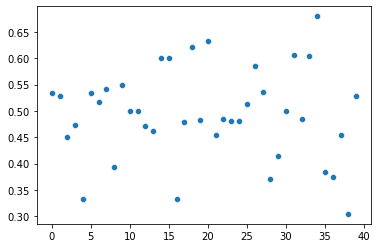

In [5]:
# Checking percentage of rows with equal values for self and other for each participant

df[df['rewardSubj']==df['rewardPart']]
frac = (df[df['rewardSubj']==df['rewardPart']].value_counts(subset=['subject'])/df.value_counts(subset=['subject']))
sns.scatterplot(y=frac, x=range(40))

#### For most participants, at least one third of the rows have equal values for self and the partner so their Charness-Rabin utility will be independent of alpha and beta. Use independent rows to regress happiness vs utilities and the rest to get alpha and beta

#### Tentative algorithm:
1) Use rows with equal values to estimate relation between happiness and utilities so that they are scaled in a sense to the same dimension while calculating for alpha and beta
2) Normalize happiness using z score
3) Calculate squared error and plot 

There is only one utility matrix in this one because there is only one dependent variable

In [6]:
# Grid parameters

steps = 11 ##### Input number of steps here
N = df.shape[0]

alpha_range = np.linspace(0, 1, steps, endpoint=True)
beta_range  = np.linspace(0, 1, steps, endpoint=True)
col = []

for alpha in alpha_range: 
    for beta in beta_range: 
        name = str(alpha), str(beta)
        col  = col + [name]

In [7]:
# Create an empty dataframe
utilities = pd.DataFrame(index=df.index, columns=col)

In [8]:
# Utility Grid

for alpha in alpha_range: 
    for beta in beta_range: 
        name = str(alpha), str(beta)
        utilities[name][df['rewardSubj']>df['rewardPart']]  = (1-beta)*df['rewardSubj'][df['rewardSubj']>df['rewardPart']]+beta*df['rewardPart'][df['rewardSubj']>df['rewardPart']]
        utilities[name][df['rewardSubj']<df['rewardPart']]  = (1-alpha)*df['rewardSubj'][df['rewardSubj']<df['rewardPart']]+alpha*df['rewardPart'][df['rewardSubj']<df['rewardPart']]
        utilities[name][df['rewardSubj']==df['rewardPart']] = df['rewardSubj'][df['rewardSubj']==df['rewardPart']]

In [9]:
# Normalize happiness (participant wise?)

mean = df['happiness'].mean()
std = df['happiness'].std()
df['z_hap'] = (df['happiness']-mean)/std

Text(0, 0.5, 'Coeff of z_hap vs utilities per participant')

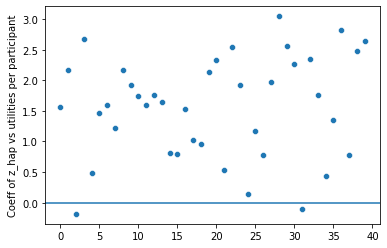

In [10]:
# Finding relation between z_happiness and utilities where utilities are independent of alpha and beta wrt subject

index = df['rewardSubj']==df['rewardPart'] # where utilities of self and other are equal

coef = []
for i in df['subject'].unique():
    indx = index & (df['subject']==i)
    y = df['z_hap'][indx].tolist()
    x = utilities.iloc[:, 0][indx].tolist()
    c = P.polyfit(x, y, deg=1)
    coef = coef + [c[1]]


graph = sns.scatterplot(y=coef, x=range(40))
graph.axhline(0)
plt.ylabel('Coeff of z_hap vs utilities per participant')

##### For two subjects happiness decreases as utility increases

In [11]:
# Calculating squared error for the rows where rewards for self and other are not equal

index = df['rewardSubj']!=df['rewardPart']
N, total_col = utilities[index].shape
trials = df[index].value_counts(subset=['subject']).sort_index()
data = []


error = utilities[index].sub(df['z_hap'][index], axis=0)
error = error**2
error['subject'] = df['subject'][index]

for i in df['subject'].unique(): # coef scales the utilities by coefficient
    data = data + [coef[i-1]*(error[error['subject']==i].sum())/trials[i]]
    
mse = pd.DataFrame(data=data)

In [12]:
#mse.head() ## uncomment to see how mse looks like 

In [13]:
# Min mse:

mse.drop(columns=['subject'], inplace=True) # Drop subject column from mse
min_mse = mse.idxmin(axis=1)

Text(0.5, 1.0, 'Alpha')

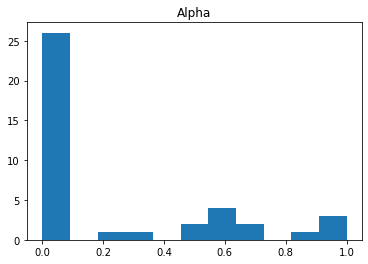

In [14]:
# Creating list of alphas for each subject

obs_alpha = []

for x in min_mse:
    obs_alpha = obs_alpha + [x[0]]
    
obs_alpha = [float(x) for x in obs_alpha]
#obs_alpha


# Plotting alpha

plt.hist(obs_alpha, bins=11)
plt.title('Alpha')

Text(0.5, 1.0, 'Beta')

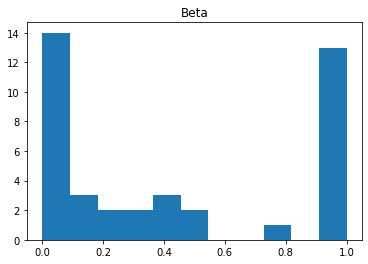

In [15]:
# Creating list of betas for each subject

obs_beta = []

for x in min_mse:
    obs_beta = obs_beta + [x[1]]
    
obs_beta = [float(x) for x in obs_beta]
# obs_beta


# PLotting beta

plt.hist(obs_beta, bins=11)
plt.title('Beta')